## Alpha Factor Evaluation

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [17]:
import alphalens
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import timedelta
from alphalens.utils import get_clean_factor_and_forward_returns
from alphalens.performance import *
from alphalens.plotting import *
from alphalens.tears import *
import pyfolio

In [3]:
%matplotlib inline
plt.style.use('fivethirtyeight')
idx = pd.IndexSlice

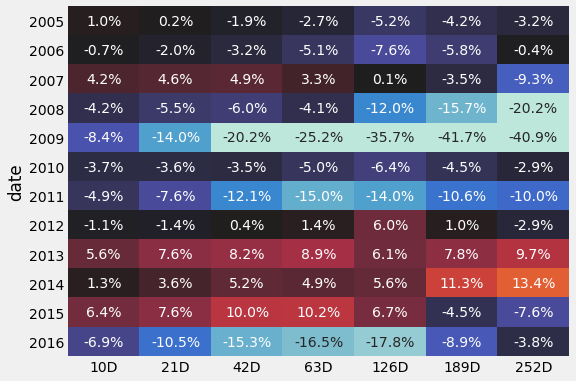

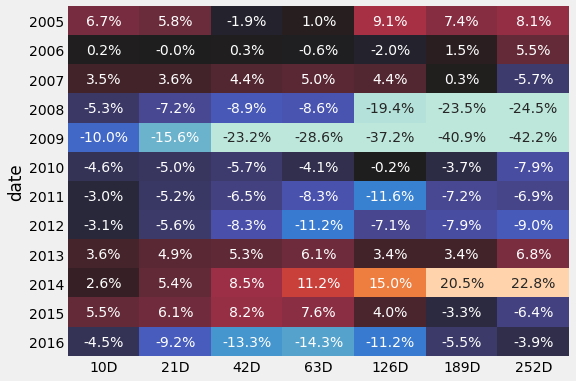

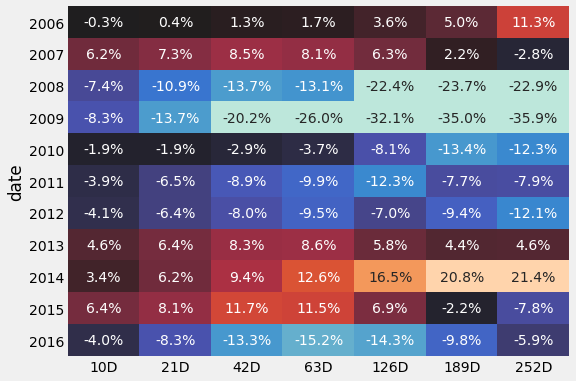

In [16]:
with pd.HDFStore('momentum_factor.h5') as store:
    for month in [12, 18, 24]:
        df = store[f'ic/{month}']
        df.index = df.index.year
        fig, ax = plt.subplots(figsize=(8,6))
        sns.heatmap(df, vmin=-.2, vmax=.2, center=0, annot=True, fmt='.1%', cbar=False)
        plt.show()
        

In [18]:
with pd.HDFStore('momentum_factor.h5') as store:
    returns = store.get('returns')
    positions = store.get('positions')
    benchmark = store.get('benchmark')

Entire data start date: 2013-01-02
Entire data end date: 2016-04-04
Backtest months: 56


Backtest
Annual return           3.2%
Cumulative returns     16.1%
Annual volatility       0.8%
Sharpe ratio            4.10
Calmar ratio            0.28
Stability               0.78
Max drawdown          -11.7%
Omega ratio             2.07
Sortino ratio           6.29
Skew                   -0.80
Kurtosis                0.76
Tail ratio              0.82
Daily value at risk    -0.1%
Gross leverage          0.70
Alpha                   0.00
Beta                    0.43

Worst drawdown periods Net drawdown in %  Peak date Valley date Recovery date  \
0                                  11.66 2015-08-03  2016-04-04           NaT   
1                                   1.24 2014-01-28  2014-04-14    2014-06-16   
2                                   0.17 2014-07-10  2014-08-06    2014-08-25   
3                                   0.12 2013-10-01  2013-11-04    2013-12-02   
4                                   0.00 2013-01-02  2013-01-02    2013-01-02   

Worst drawdown periods Duration  
0                           NaN  
1                           100  
2                            33  
3                            45  
4                             1

ValueError: Found input variables with inconsistent numbers of samples: [127, 183]

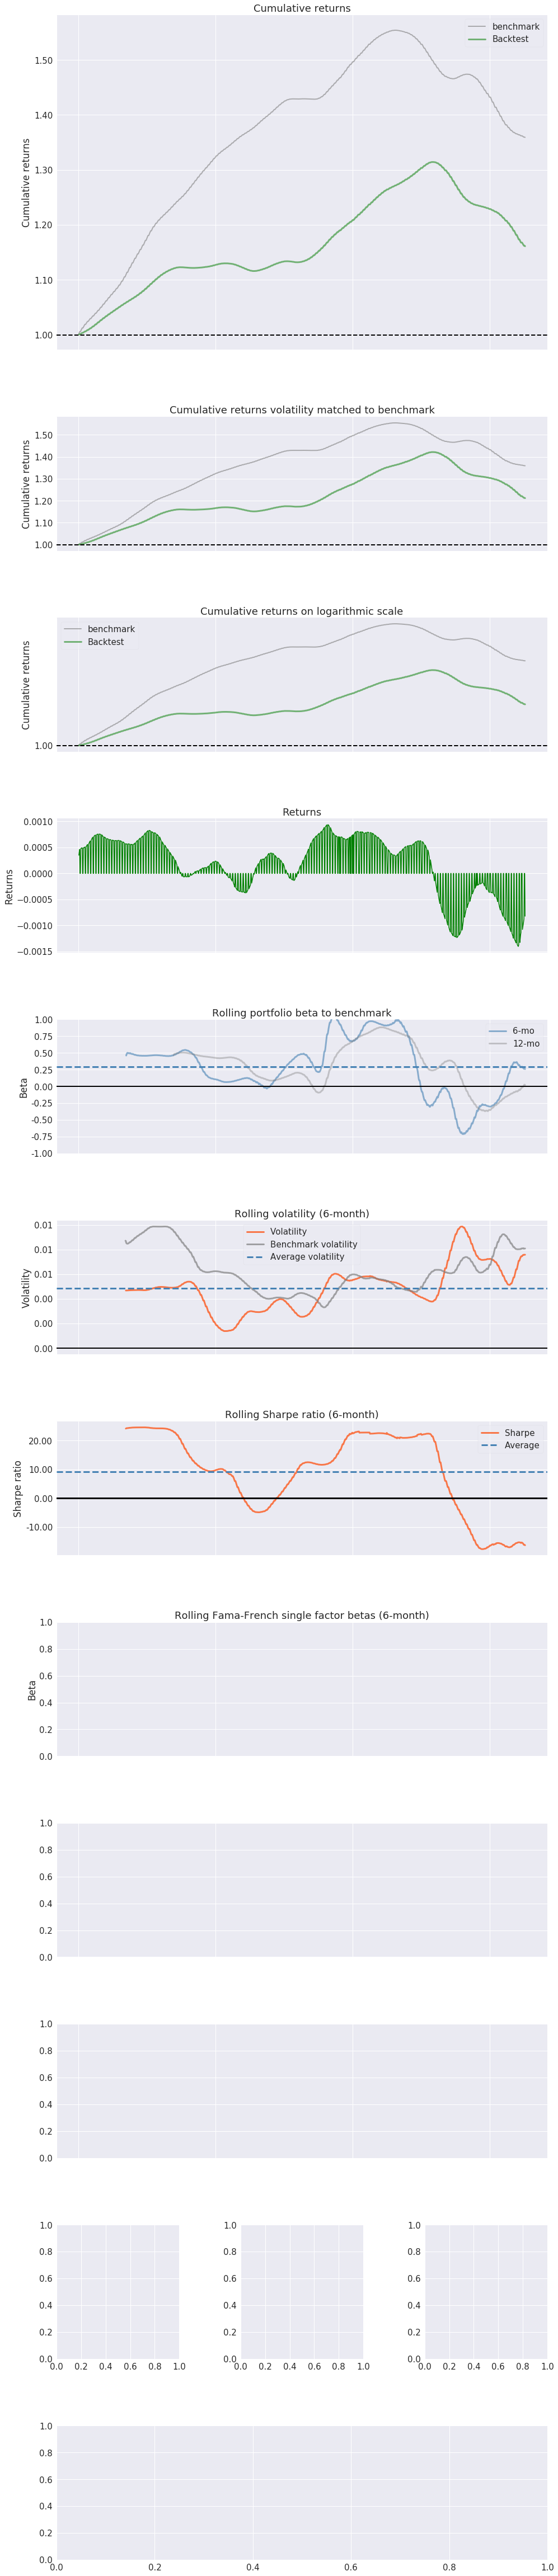

In [20]:
pyfolio.tears.create_full_tear_sheet(returns,
                                     positions=positions,
                                     benchmark_rets=benchmark)

### Get Data

In [4]:
def get_quandl_wiki(stocks='all', start=2010, end=2017, na_thres=.8):
    with pd.HDFStore('assets.h5') as store:
        df = store.get('wiki').adj_close.unstack().loc[str(start):str(end)]
        if isinstance(stocks, list):
            df = df.loc[:, stocks]
        return df.dropna(thresh=int(len(df) * na_thres), axis=1)

In [152]:
def get_sp500(start=2010, end=2017):
    with pd.HDFStore('assets.h5') as store:
        sp500 = store['sp500'].Close.loc[str(start):str(end)]
        return sp500.to_frame('sp500')


def get_sp500_fw(start=2010, end=2017, periods=(1, 5, 10)):
    sp500 = get_sp500(start, end).resample('D').ffill()
    df = pd.concat([(sp500
                     .pct_change(periods=fw)
                     .shift(-fw)
                     .squeeze()
                     .to_frame(f'{fw}D')) for fw in periods], axis=1)
    return df.dropna()

def get_benchmark(factor_data):
    factor_dates = factor_data.index.get_level_values('date').unique()
    start = factor_dates.min().year
    last = (factor_dates.max() + BDay(max(periods))).year + 1
    return get_sp500_fw(start=start, end=last, periods=periods).reindex(factor_dates)

In [63]:
with pd.HDFStore('momentum_strategy.h5') as store:
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: momentum_strategy.h5
/factor/12                          frame        (shape->[3571,1731])
/factor/18                          frame        (shape->[3445,1731])
/factor/24                          frame        (shape->[3319,1731])
/factor/6                           frame        (shape->[3697,1731])
/factor_data/12                     frame        (shape->[5765946,9])
/factor_data/18                     frame        (shape->[5547839,9])
/factor_data/24                     frame        (shape->[5329739,9])
/factor_data/6                      frame        (shape->[5843841,9])
/period_factor/12/3/2007            frame        (shape->[1863466,9])
/period_factor/12/3/2010            frame        (shape->[1868190,9])
/period_factor/12/3/2013            frame        (shape->[1864980,9])
/period_factor/12/3/2016            frame        (shape->[1830437,9])
/period_factor/12/3/2019            frame        (shape->[26334,9])  
/period_factor/12/4/

In [107]:
def get_factor_data(ma=24, d=6, yr=2016):
    with pd.HDFStore('momentum_strategy.h5') as store:        
        pf = store[f'period_factor/{ma}/{d}/{yr}']
        stocks = pf.index.get_level_values('asset').unique()
        f = store[f'factor_data/{ma}'].loc[idx[str(yr-d+1):str(yr), stocks], :]
        return f

In [54]:
cols = ['ma', 'period', 'duration', 'year', 'alpha', 'beta', 'ic'] + list(range(1, 6))
with pd.HDFStore('momentum_strategy.h5') as hdf:
    results = hdf.get('results').loc[:, cols]
results = results[(results.year - results.duration) < 2015]
# results.period = results.period.str.replace('D', '').astype(int)

In [56]:
results.groupby(['ma', 'year', 'duration']).mean().sort_values('alpha', ascending=False).head(20)

alpha      beta        ic         1         2         3  \
ma year duration                                                               
6  2015 3         0.061020  0.260468  0.161666 -0.059708  0.004787  0.011876   
        4         0.050737  0.270228  0.169437 -0.052986 -0.005579  0.007214   
12 2016 4         0.049036  0.321739  0.193117 -0.070534 -0.010157  0.007468   
18 2016 4         0.047333  0.349882  0.179706 -0.069365 -0.014294  0.005604   
24 2014 3         0.040375  0.411073  0.166816 -0.051008 -0.005561 -0.000437   
   2015 5         0.039638  0.365642  0.154212 -0.052634  0.002017  0.005006   
18 2016 3         0.034197  0.400065  0.178664 -0.083844 -0.019122  0.008594   
6  2018 5         0.032401  0.296114  0.197159 -0.046483  0.007433 -0.005404   
12 2016 3         0.030146  0.440631  0.225581 -0.088253 -0.014127  0.014122   
18 2007 3         0.028379  0.323909  0.173922 -0.053475 -0.020359 -0.012365   
24 2005 5         0.025336  0.206351  0.182321 -0.044570 -0.032069 -0.011717   
        4         0.025336  0.206351  0.182321 -0.044570 -0.032069 -0.011717   
        3         0.025336  0.206351  0.182321 -0.044570 -0.032069 -0.011717   
   2008 3         0.023898  0.569828  0.171084 -0.052925 -0.017331  0.001763   
   2017 4         0.023769  0.394652  0.144273 -0.079355 -0.015126  0.007199   
12 2007 3         0.019862  0.331278  0.185506 -0.059341 -0.027792 -0.008294   
18 2014 5         0.011810  0.470550  0.180480 -0.059579 -0.017937  0.002026   
12 2014 5         0.011352  0.442964  0.174050 -0.059824 -0.020346 -0.001086   
6  2007 4         0.004938  0.307755  0.178189 -0.046874 -0.025502 -0.011999   
12 2019 5         0.004306  0.356117  0.171245  0.021751 -0.020452 -0.014981   

                         4         5  
ma year duration                      
6  2015 3         0.009501  0.032226  
        4         0.011230  0.041914  
12 2016 4         0.017885  0.055043  
18 2016 4         0.020519  0.042580  
24 2014 3         0.011985  0.044157  
   2015 5         0.011810  0.031187  
18 2016 3         0.026741  0.042193  
6  2018 5         0.010325  0.044599  
12 2016 3         0.030393  0.060014  
18 2007 3         0.008972  0.057647  
24 2005 5         0.020317  0.060796  
        4         0.020317  0.060796  
        3         0.020317  0.060796  
   2008 3         0.015372  0.035706  
   2017 4         0.028484  0.026509  
12 2007 3         0.012671  0.070877  
18 2014 5         0.020698  0.053476  
12 2014 5         0.020609  0.055492  
6  2007 4         0.006701  0.074725  
12 2019 5        -0.011056  0.030463

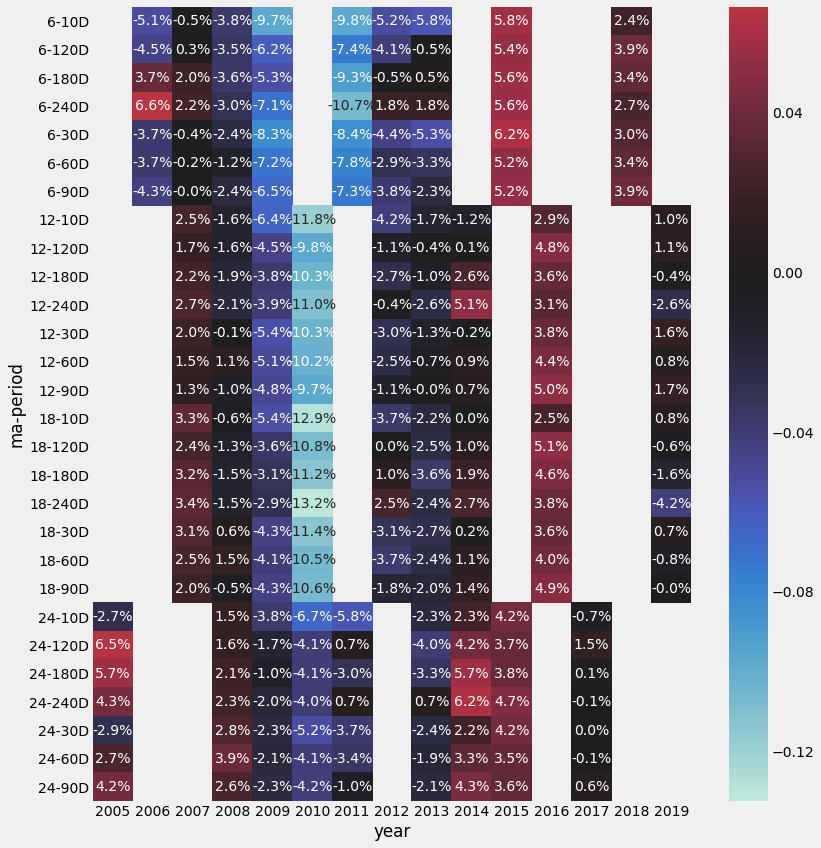

In [212]:
df = results.groupby(['ma', 'year', 'period']).alpha.mean().unstack('year')
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(df, center=0, annot=True, fmt='.1%', ax=ax)
fig.tight_layout();

In [87]:
periods = [10, 30, 60, 90, 120, 180, 240]
period_cols = [f'{p}D' for p in periods]

In [183]:
factor_data= get_factor_data(ma=18, d=4, yr=2016).loc[idx['2013': '2015', :], :]
factor_data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 522489 entries, (2012-01-02 00:00:00, ABC) to (2014-12-31 00:00:00, ZBRA)
Data columns (total 9 columns):
10D                522489 non-null float64
30D                522489 non-null float64
60D                522489 non-null float64
90D                522489 non-null float64
120D               522489 non-null float64
180D               522489 non-null float64
240D               522489 non-null float64
factor             522489 non-null float64
factor_quantile    522489 non-null int64
dtypes: float64(8), int64(1)
memory usage: 37.9+ MB


In [190]:
factor_data.reset_index().drop_duplicates(subset=['date', 'asset']).info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 522489 entries, 0 to 524050
Data columns (total 12 columns):
date               522489 non-null datetime64[ns]
asset              522489 non-null object
10D                522489 non-null float64
30D                522489 non-null float64
60D                522489 non-null float64
90D                522489 non-null float64
120D               522489 non-null float64
180D               522489 non-null float64
240D               522489 non-null float64
factor             522489 non-null float64
factor_quantile    522489 non-null int64
group              462352 non-null object
dtypes: datetime64[ns](1), float64(8), int64(1), object(2)
memory usage: 51.8+ MB


In [184]:
len(factor_data.index.get_level_values('asset').unique())

669

In [88]:
factor_data.loc[:, period_cols].dropna(how='all').info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2467840 entries, (2013-01-01 00:00:00, ABC) to (2016-12-30 00:00:00, ZBH)
Data columns (total 7 columns):
10D     350208 non-null float64
30D     351232 non-null float64
60D     353280 non-null float64
90D     353280 non-null float64
120D    353280 non-null float64
180D    353280 non-null float64
240D    353280 non-null float64
dtypes: float64(7)
memory usage: 141.2+ MB


## Sector Information

In [185]:
sectors = pd.read_csv('../nasdaq-sectors.csv', index_col='Symbol').Sector
sectors.head()

Symbol
PIH                Finance
PIHPP              Finance
TURN               Finance
FLWS     Consumer Services
FCCY               Finance
Name: Sector, dtype: object

In [186]:
factor_data = factor_data.reset_index().merge(sectors.to_frame('group'), left_on='asset', right_index=True, how='left').set_index(['date', 'asset'])

In [187]:
factor_data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 524051 entries, (2012-01-02 00:00:00, ABC) to (2014-12-31 00:00:00, ZBRA)
Data columns (total 10 columns):
10D                524051 non-null float64
30D                524051 non-null float64
60D                524051 non-null float64
90D                524051 non-null float64
120D               524051 non-null float64
180D               524051 non-null float64
240D               524051 non-null float64
factor             524051 non-null float64
factor_quantile    524051 non-null int64
group              463914 non-null object
dtypes: float64(8), int64(1), object(1)
memory usage: 42.0+ MB


## Formatting input data

Alphalens contains a handy data formatting function to transform your factor and pricing data into the exact inputs expected by the tear sheet functions.

Quantiles Statistics


min        max      mean       std   count    count %
factor_quantile                                                            
1               -0.959020   0.301895 -0.205844  0.255205  105738  20.177044
2               -0.225352   0.546121  0.155994  0.146549  110027  20.995476
3               -0.015186   0.805955  0.337161  0.155802  102213  19.504399
4                0.152205   1.235494  0.549763  0.193173   99971  19.076578
5                0.389873  17.263804  1.267737  0.928044  106102  20.246503

Returns Analysis


10D     30D     60D     90D  \
Ann. alpha                                      0.073   0.086   0.096   0.099   
beta                                            0.006   0.001  -0.031  -0.074   
Mean Period Wise Return Top Quantile (bps)     33.665  36.273  36.258  35.002   
Mean Period Wise Return Bottom Quantile (bps) -32.146 -35.256 -34.326 -30.906   
Mean Period Wise Spread (bps)                  64.045  69.996  69.460  65.223   

                                                 120D    180D    240D  
Ann. alpha                                      0.101   0.107   0.110  
beta                                           -0.132  -0.241  -0.340  
Mean Period Wise Return Top Quantile (bps)     33.042  27.411  20.091  
Mean Period Wise Return Bottom Quantile (bps) -25.532 -19.984 -16.447  
Mean Period Wise Spread (bps)                  57.686  46.179  35.142

Information Analysis


10D     30D     60D     90D    120D    180D    240D
IC Mean            0.049   0.082   0.112   0.127   0.132   0.141   0.135
IC Std.            0.108   0.109   0.110   0.113   0.114   0.122   0.138
Risk-Adjusted IC   0.451   0.753   1.014   1.124   1.159   1.152   0.977
t-stat(IC)        12.597  21.039  28.328  31.413  32.396  32.202  27.309
p-value(IC)        0.000   0.000   0.000   0.000   0.000   0.000   0.000
IC Skew           -0.133  -0.422  -0.246  -0.160   0.200   0.245   0.085
IC Kurtosis        0.003   0.173  -0.631  -0.743  -1.017  -1.330  -1.450

ValueError: Index contains duplicate entries, cannot reshape

<Figure size 432x288 with 0 Axes>

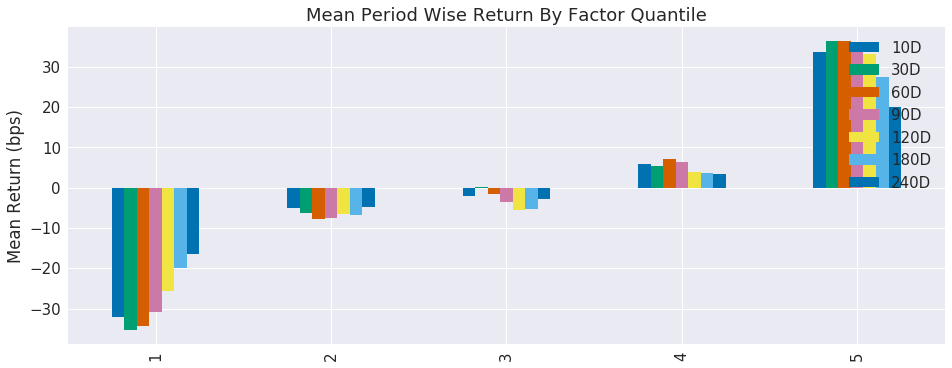

In [188]:
create_summary_tear_sheet(factor_data)

# Returns Analysis

Returns analysis gives us a raw description of a factor's value that shows us the power of a factor in real currency values.

One of the most basic ways to look at a factor's predicitve power is to look at the mean return of different factor quantile. 

In [191]:
mean_return_by_q_daily, std_err = mean_return_by_quantile(factor_data, by_date=True)

In [192]:
mean_return_by_q_daily.head()

10D       30D       60D       90D      120D  \
factor_quantile date                                                           
1               2012-01-02  0.026853  0.039017  0.026560 -0.020039 -0.054012   
                2012-01-03  0.012600  0.023510  0.006743 -0.036327 -0.065972   
                2012-01-04  0.013146  0.020977  0.010866 -0.037835 -0.054389   
                2012-01-05  0.020005  0.033756  0.015266 -0.039278 -0.048314   
                2012-01-06  0.013559  0.028458  0.001045 -0.062417 -0.065248   

                                180D      240D  
factor_quantile date                            
1               2012-01-02 -0.084851 -0.119063  
                2012-01-03 -0.098695 -0.131422  
                2012-01-04 -0.088678 -0.130724  
                2012-01-05 -0.076502 -0.121572  
                2012-01-06 -0.099045 -0.141679

In [193]:
mean_return_by_q, std_err_by_q = mean_return_by_quantile(factor_data, by_date=False)

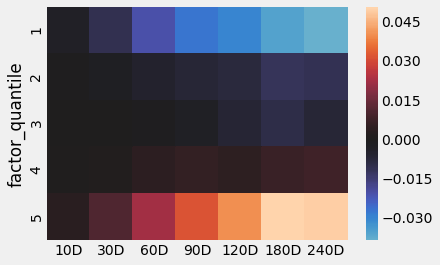

In [194]:
sns.heatmap(mean_return_by_q, center=0);

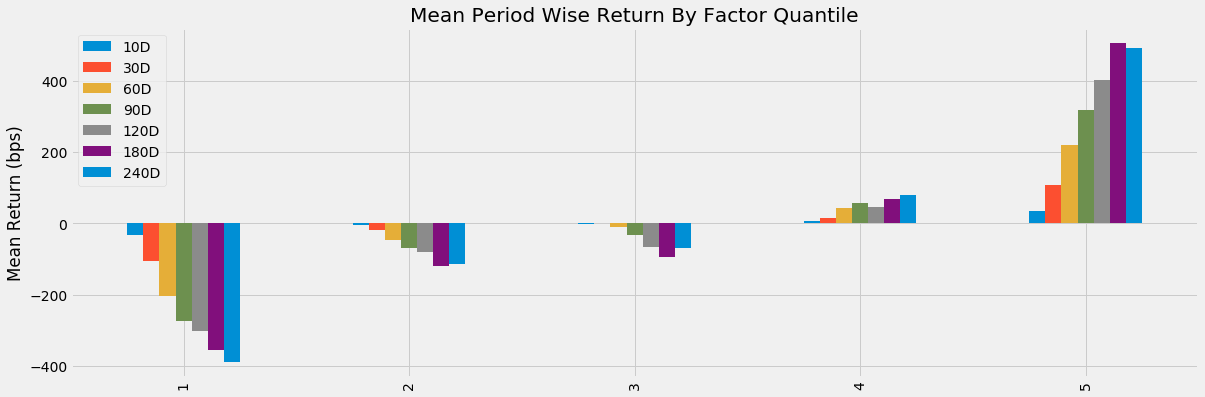

In [195]:
plot_quantile_returns_bar(mean_return_by_q);

By looking at the mean return by quantile we can get a real look at how well the factor differentiates forward returns across the signal values. Obviously we want securities with a better signal to exhibit higher returns. For a good factor we'd expect to see negative values in the lower quartiles and positive values in the upper quantiles.

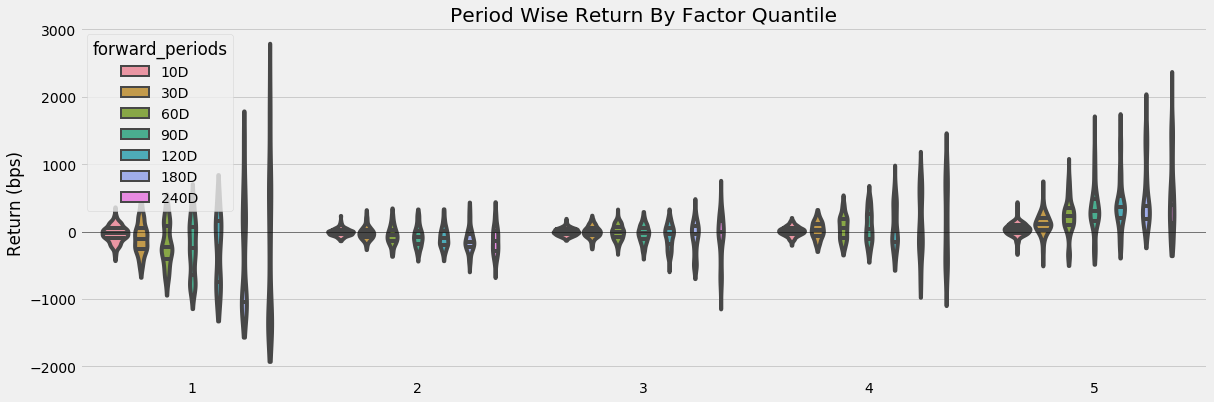

In [196]:
plot_quantile_returns_violin(mean_return_by_q_daily);

This violin plot is similar to the one before it but shows more information about the underlying data. It gives a better idea about the range of values, the median, and the inter-quartile range. What gives the plots their shape is the application of a probability density of the data at different values.

In [197]:
quant_return_spread, std_err_spread = compute_mean_returns_spread(mean_return_by_q_daily,
                                                                  lower_quant=1,
                                                                  upper_quant=5,
                                                                  std_err=std_err)

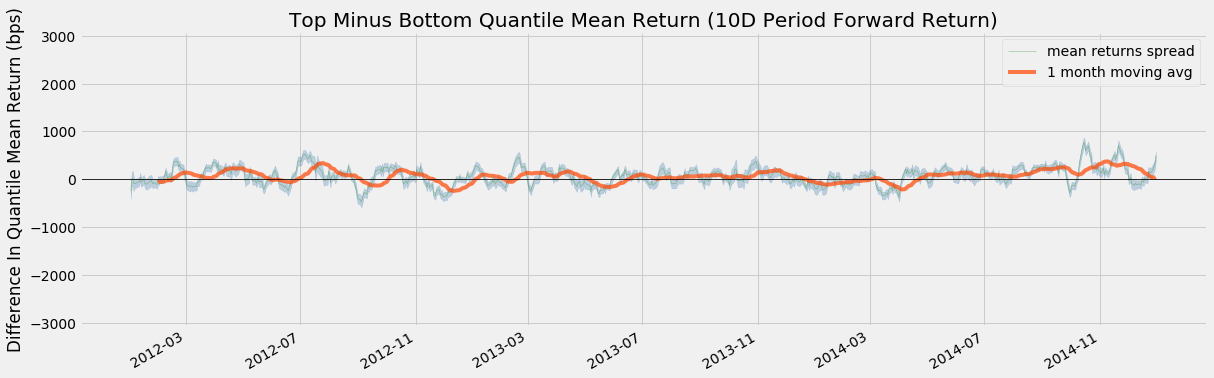

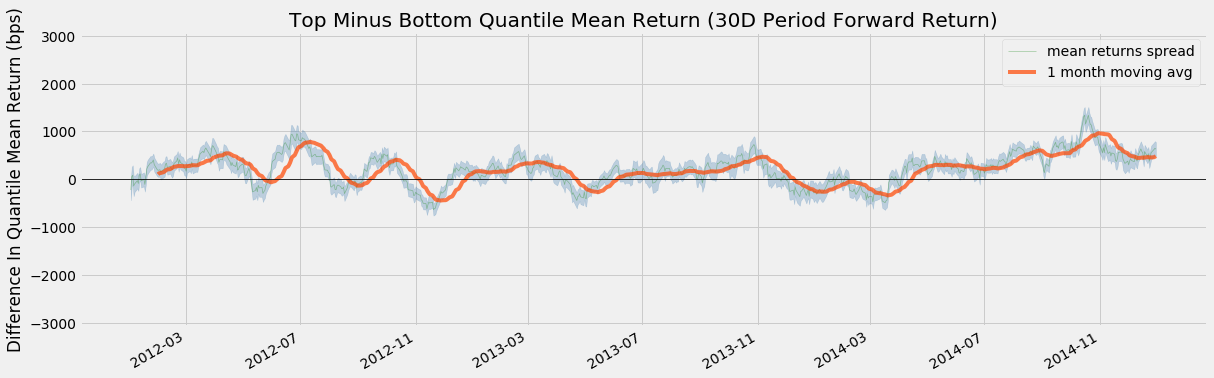

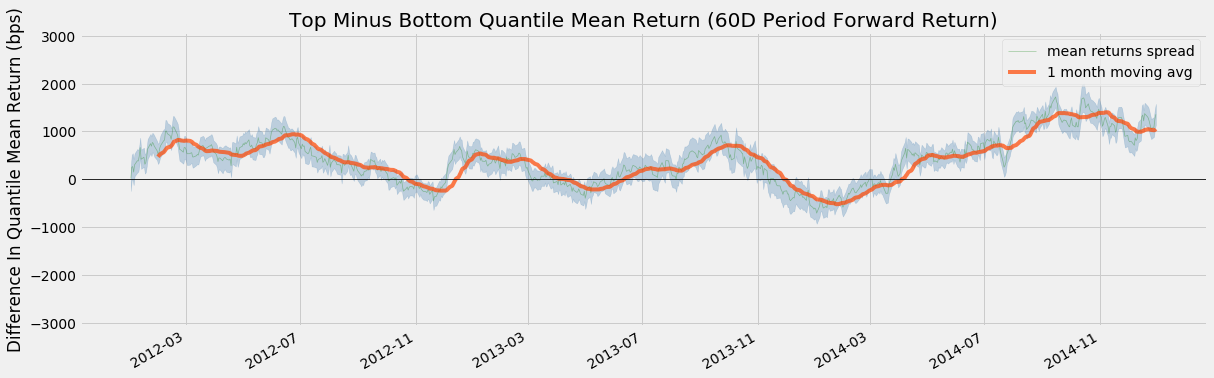

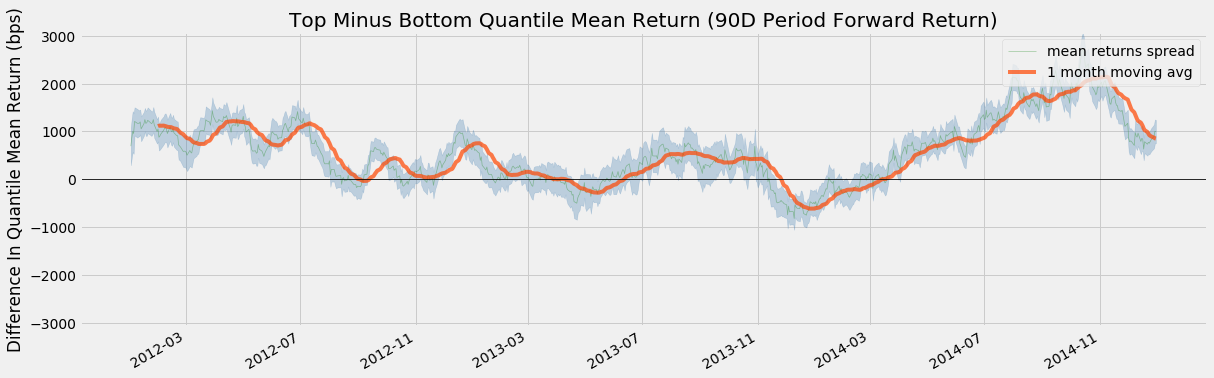

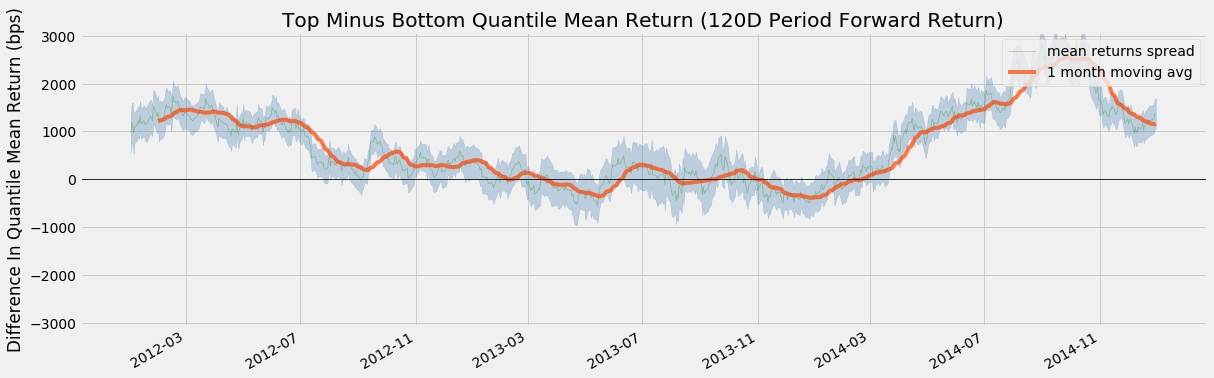

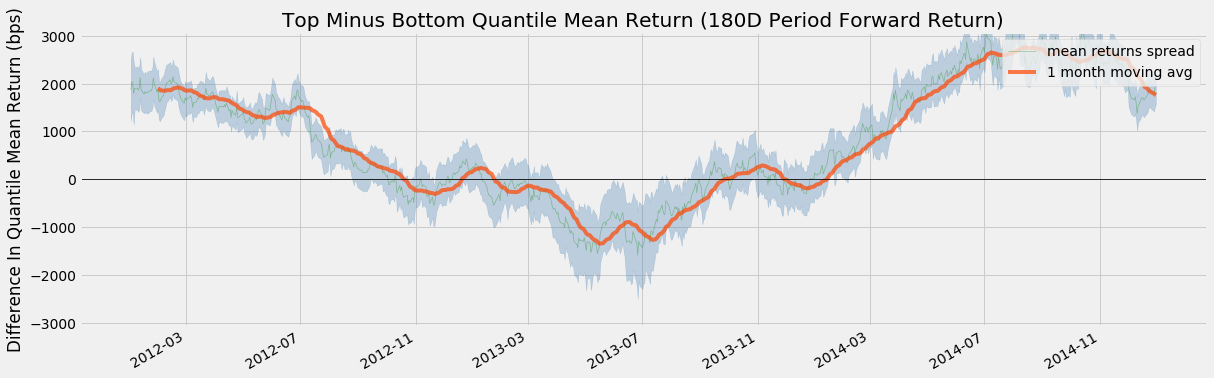

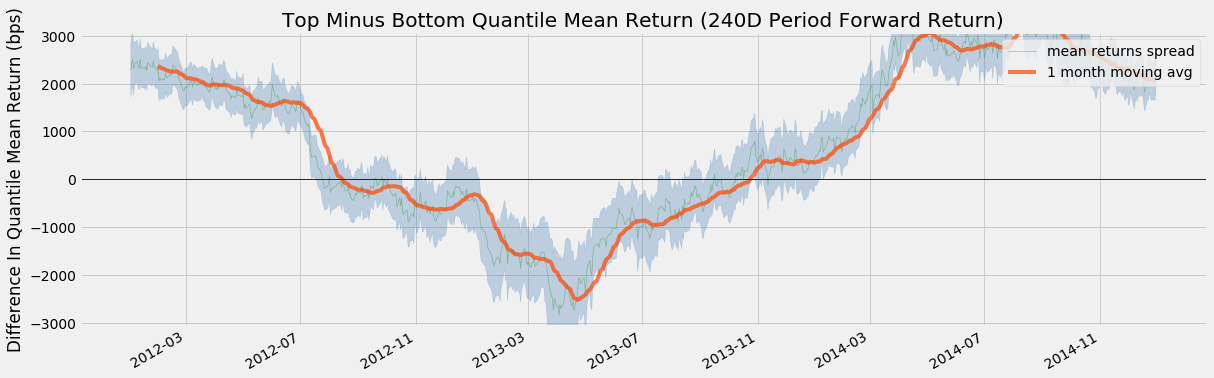

In [198]:
plot_mean_quantile_returns_spread_time_series(quant_return_spread, std_err_spread);

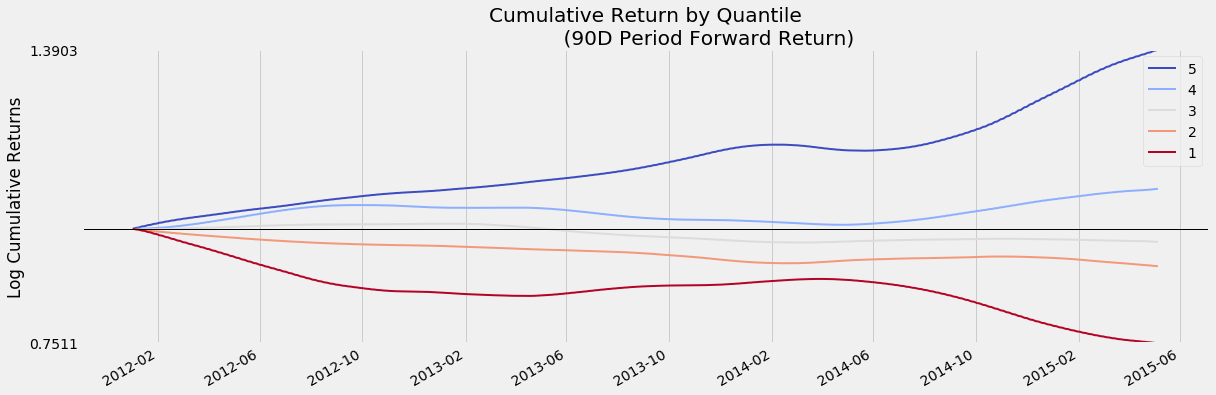

In [199]:
plot_cumulative_returns_by_quantile(mean_return_by_q_daily['90D'], period='90D');

By looking at the cumulative returns by factor quantile we can get an intuition for which quantiles are contributing the most to the factor and at what time. Ideally we would like to see a these curves originate at the same value on the left and spread out like a fan as they move to the right through time, with the higher quantiles on the top.

In [200]:
ls_factor_returns = factor_returns(factor_data)

In [201]:
ls_factor_returns.head()

10D       30D       60D       90D      120D      180D  \
date                                                                     
2012-01-02 -0.004927 -0.007802  0.006019  0.048953  0.059134  0.079941   
2012-01-03  0.005891  0.002813  0.013937  0.050002  0.067631  0.088470   
2012-01-04  0.001286 -0.000677  0.008056  0.050614  0.061311  0.082195   
2012-01-05 -0.002484 -0.010784  0.001334  0.048749  0.054504  0.074020   
2012-01-06 -0.005211 -0.008057  0.007334  0.058360  0.061211  0.083100   

                240D  
date                  
2012-01-02  0.100560  
2012-01-03  0.107172  
2012-01-04  0.101114  
2012-01-05  0.094926  
2012-01-06  0.102780

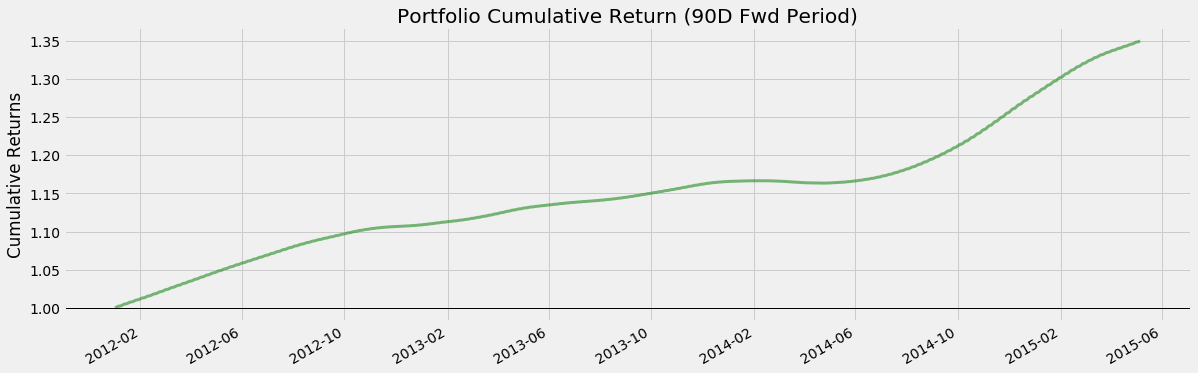

In [202]:
plot_cumulative_returns(ls_factor_returns['90D'], period='90D');

While looking at quantiles is important we must also look at the factor returns as a whole. The cumulative factor long/short returns plot lets us view the combined effects overtime of our entire factor.

In [203]:
benchmark = get_benchmark(factor_data)

In [204]:
alpha_beta = factor_alpha_beta(factor_data, returns=benchmark.fillna(0))

In [205]:
alpha_beta

10D       30D       60D       90D      120D      180D  \
Ann. alpha  0.016207  0.016955  0.023793  0.032079  0.026813  0.043779   
beta        0.526403  0.527931  0.483219  0.416181  0.435655  0.357020   

                240D  
Ann. alpha  0.032568  
beta        0.434529

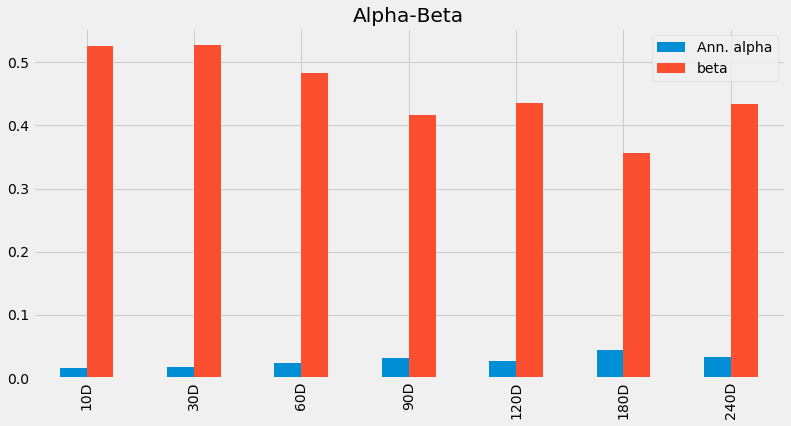

In [206]:
alpha_beta.T.plot.bar(title='Alpha-Beta', figsize=(12,6));

## Returns Tear Sheet

We can view all returns analysis calculations together.

Returns Analysis


10D     30D     60D     90D  \
Ann. alpha                                      0.073   0.086   0.096   0.099   
beta                                            0.006   0.001  -0.031  -0.074   
Mean Period Wise Return Top Quantile (bps)     33.665  36.273  36.258  35.002   
Mean Period Wise Return Bottom Quantile (bps) -32.146 -35.256 -34.326 -30.906   
Mean Period Wise Spread (bps)                  64.045  69.996  69.460  65.223   

                                                 120D    180D    240D  
Ann. alpha                                      0.101   0.107   0.110  
beta                                           -0.132  -0.241  -0.340  
Mean Period Wise Return Top Quantile (bps)     33.042  27.411  20.091  
Mean Period Wise Return Bottom Quantile (bps) -25.532 -19.984 -16.447  
Mean Period Wise Spread (bps)                  57.686  46.179  35.142

<Figure size 432x288 with 0 Axes>

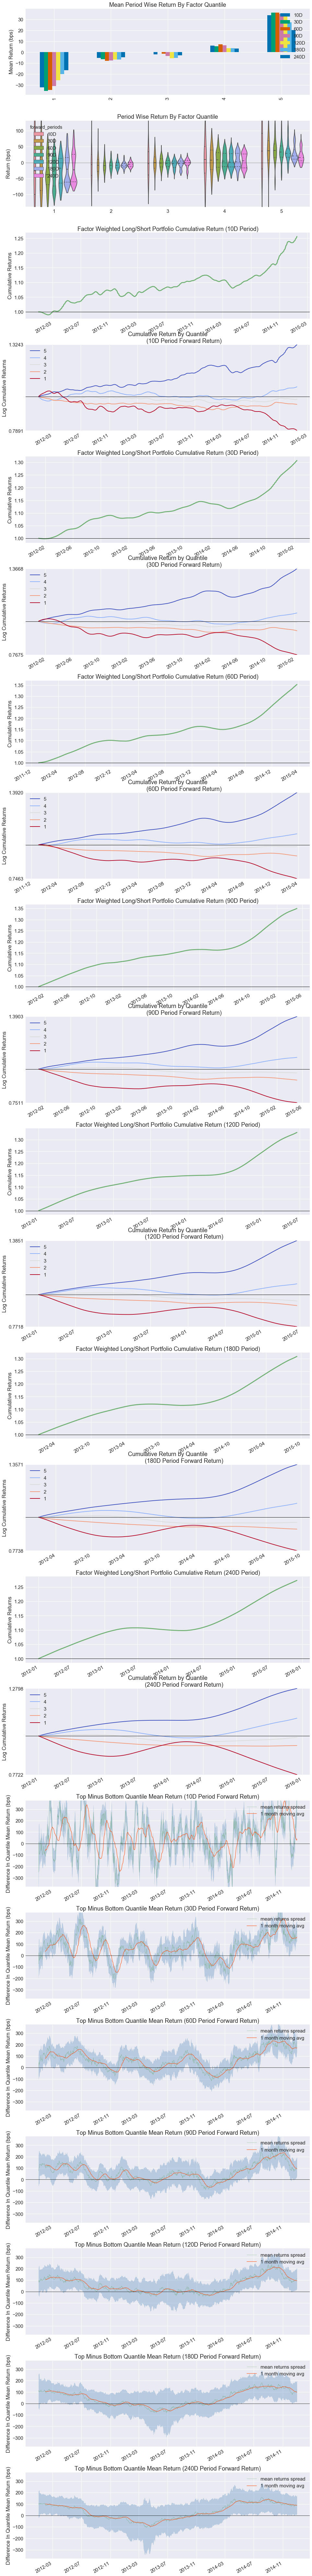

In [207]:
alphalens.tears.create_returns_tear_sheet(factor_data)

# Information Analysis

Information Analysis is a way for us to evaluate the predicitive value of a factor without the confounding effects of transaction costs. The main way we look at this is through the Information Coefficient (IC).

From Wikipedia...

>The information coefficient (IC) is a measure of the merit of a predicted value. In finance, the information coefficient is used as a performance metric for the predictive skill of a financial analyst. The information coefficient is similar to correlation in that it can be seen to measure the linear relationship between two random variables, e.g. predicted stock returns and the actualized returns. The information coefficient ranges from 0 to 1, with 0 denoting no linear relationship between predictions and actual values (poor forecasting skills) and 1 denoting a perfect linear relationship (good forecasting skills).

In [158]:
ic = factor_information_coefficient(factor_data)

In [159]:
ic.head()

10D       30D       60D       90D      120D      180D  \
date                                                                     
2013-01-01  0.104567  0.003728  0.015207  0.113432  0.113965  0.126523   
2013-01-02  0.065018 -0.000979  0.019888  0.104269  0.104567  0.121969   
2013-01-03  0.122005  0.007003  0.047399  0.132030  0.115942  0.128694   
2013-01-04  0.133777  0.005334  0.046732  0.140301  0.089924  0.125040   
2013-01-07  0.146174  0.003104  0.057340  0.146255  0.086032  0.118860   

                240D  
date                  
2013-01-01  0.097390  
2013-01-02  0.096775  
2013-01-03  0.098808  
2013-01-04  0.099193  
2013-01-07  0.096437

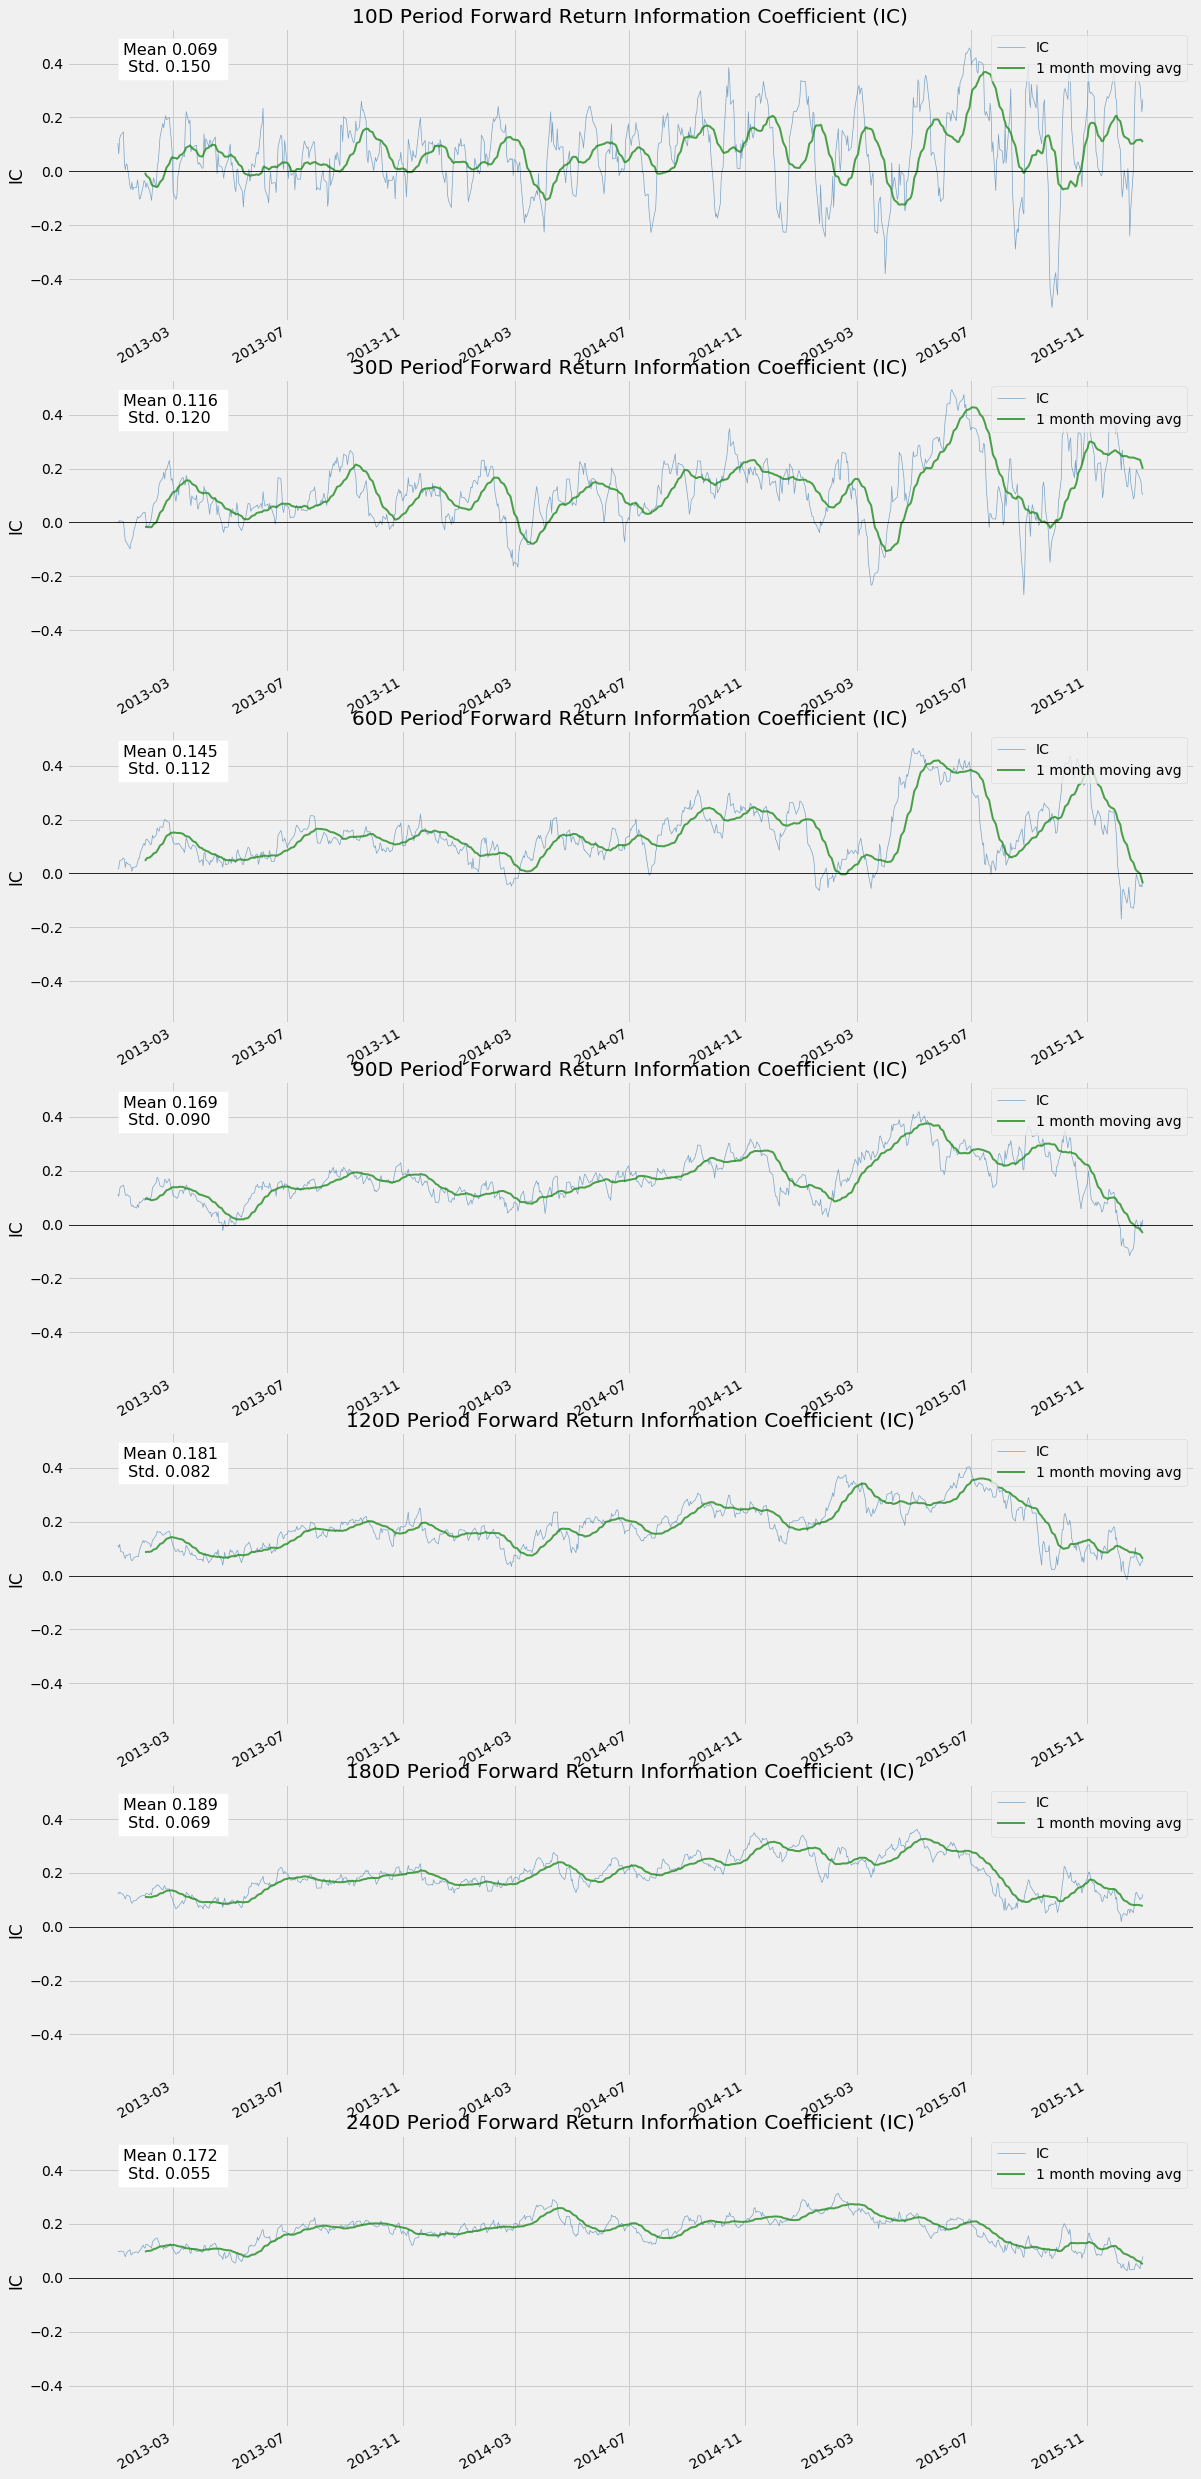

In [160]:
plot_ic_ts(ic);

By looking at the IC each day we can understand how theoretically predicitive our factor is overtime. We like our mean IC to be high and the standard deviation, or volatility of it, to be low. We want to find consistently predictive factors.

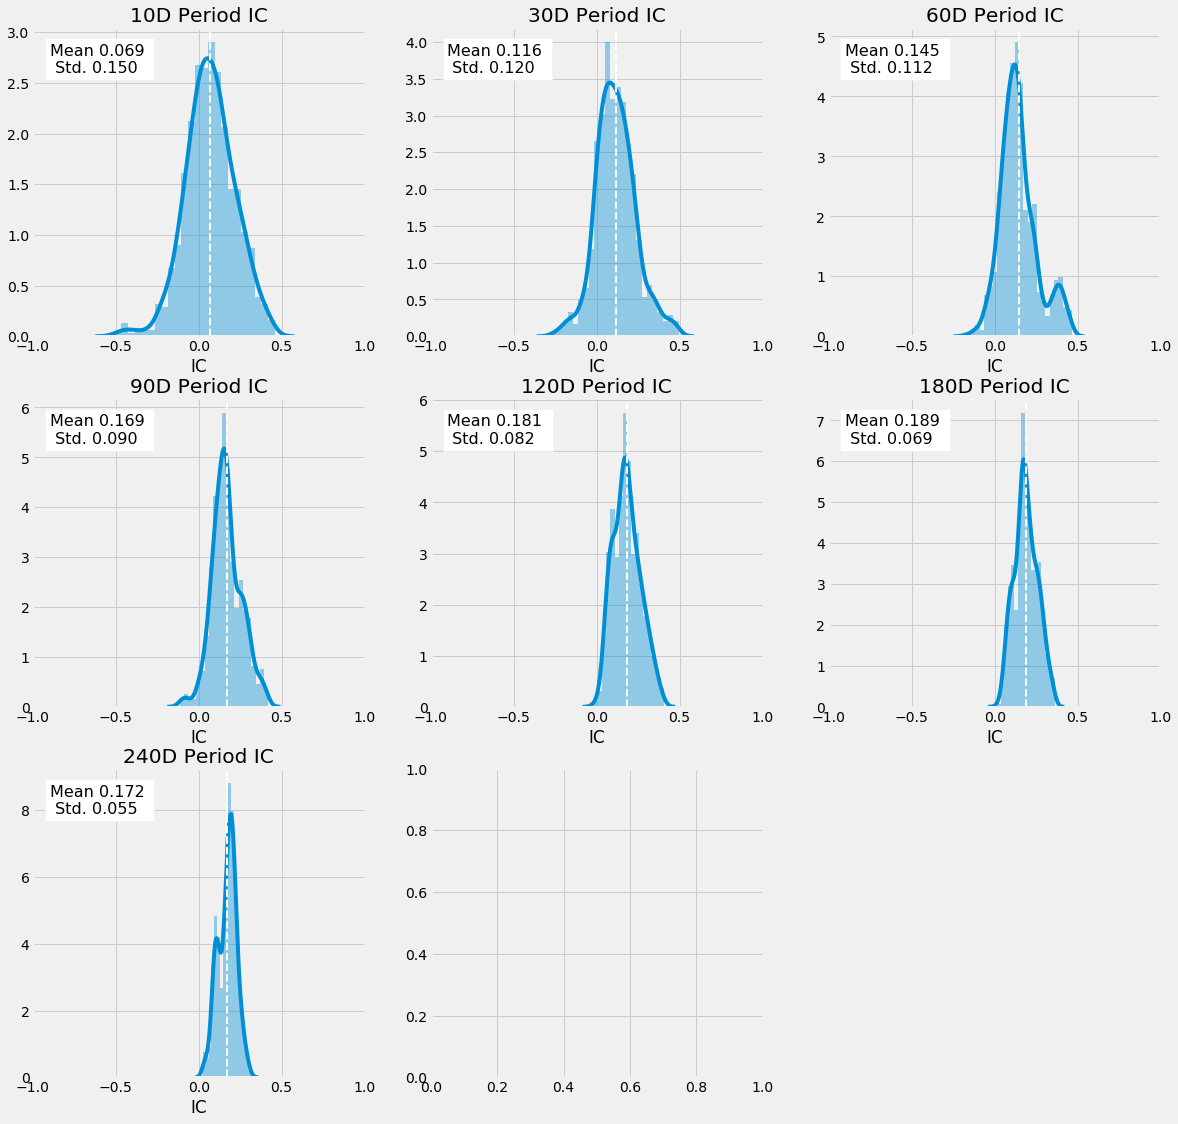

In [161]:
plot_ic_hist(ic);

Looking at a histogram of the daily IC values can indicate how the factor behaves most of the time, where the likely IC values will fall, it also allows us to see if the factor has fat tails.

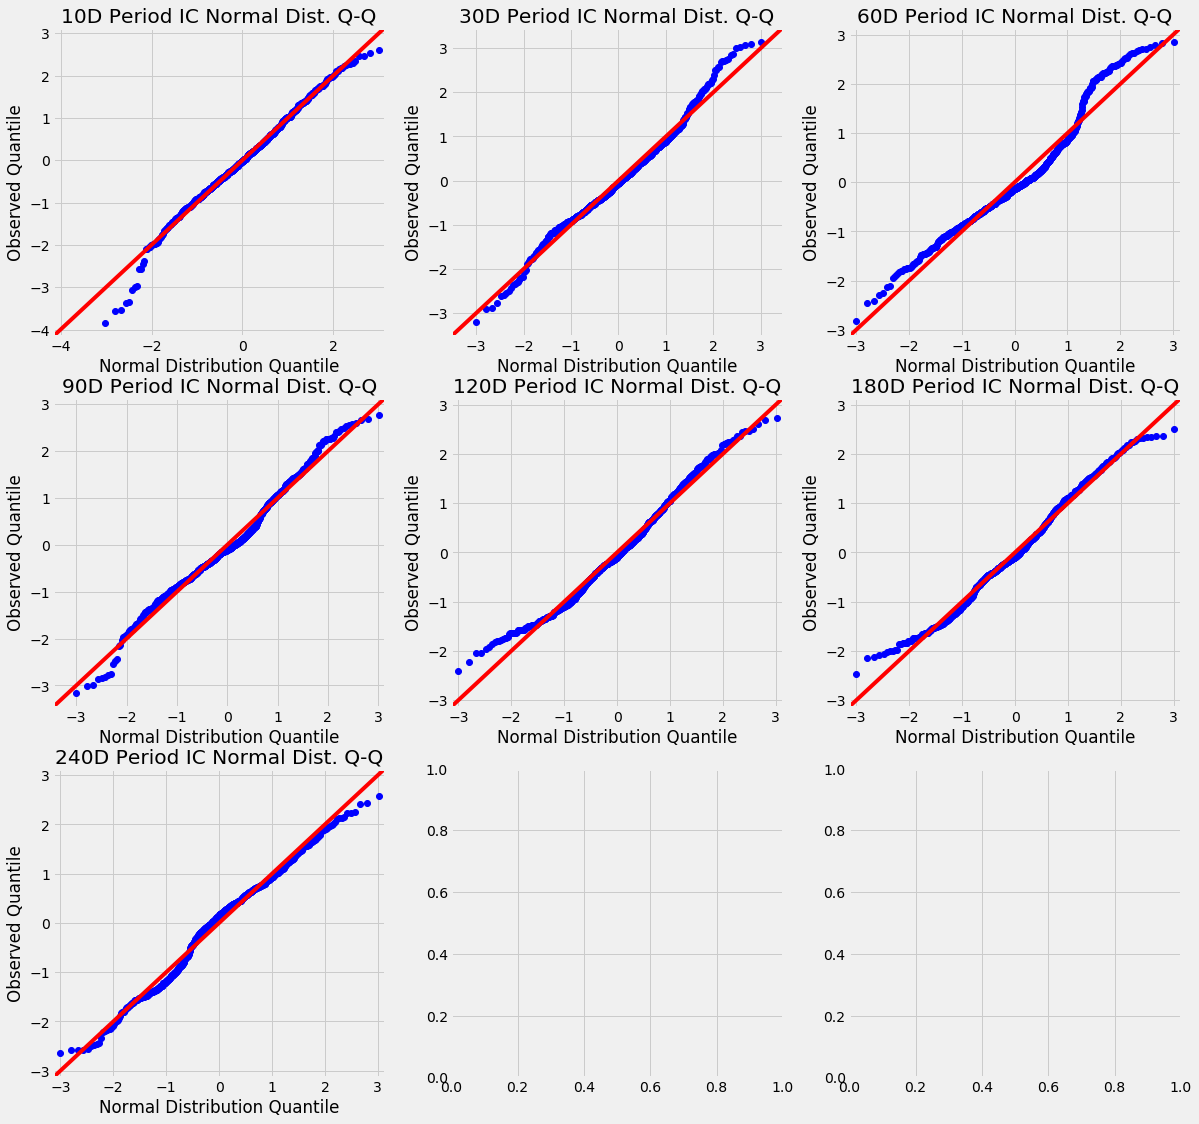

In [162]:
plot_ic_qq(ic);

These Q-Q plots show the difference in shape between the distribution of IC values and a normal distribution. This is especially helpful in seeing how the most extreme values in the distribution affect the predicitive power.

In [163]:
mean_monthly_ic = mean_information_coefficient(factor_data, by_time='M')

In [164]:
mean_monthly_ic.head()

10D       30D       60D       90D      120D      180D  \
date                                                                     
2013-01-31 -0.007712 -0.015641  0.050102  0.096397  0.088494  0.110731   
2013-02-28  0.062641  0.116102  0.155075  0.141921  0.144033  0.136124   
2013-03-31  0.056438  0.110800  0.095486  0.110959  0.083273  0.092614   
2013-04-30  0.057060  0.046289  0.049408  0.033960  0.068450  0.086282   
2013-05-31 -0.008851  0.036548  0.061008  0.070062  0.091087  0.118140   

                240D  
date                  
2013-01-31  0.097954  
2013-02-28  0.122588  
2013-03-31  0.102145  
2013-04-30  0.101732  
2013-05-31  0.095660

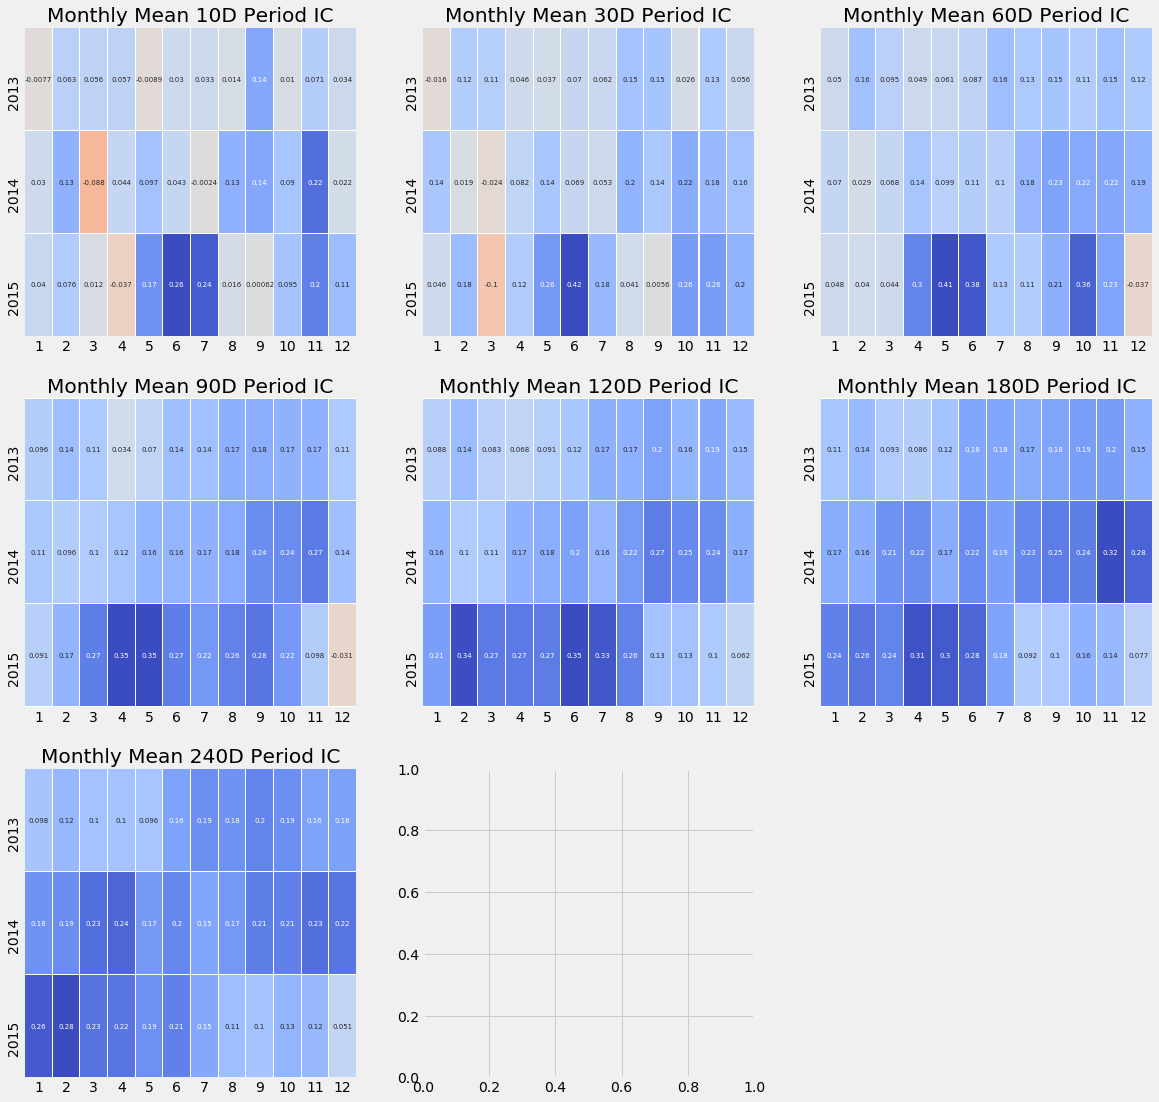

In [165]:
plot_monthly_ic_heatmap(mean_monthly_ic);

## Information Tear Sheet

We can view all information analysis calculations together.

Information Analysis


10D     30D     60D     90D    120D    180D    240D
IC Mean            0.069   0.116   0.145   0.169   0.181   0.189   0.172
IC Std.            0.150   0.120   0.112   0.090   0.082   0.069   0.055
Risk-Adjusted IC   0.460   0.963   1.297   1.873   2.214   2.734   3.111
t-stat(IC)        12.772  26.768  36.024  52.047  61.520  75.959  86.445
p-value(IC)        0.000   0.000   0.000   0.000   0.000   0.000   0.000
IC Skew           -0.203   0.277   0.716   0.195   0.311   0.148  -0.243
IC Kurtosis        0.575   0.689   0.526   0.313  -0.454  -0.532  -0.405

<Figure size 432x288 with 0 Axes>

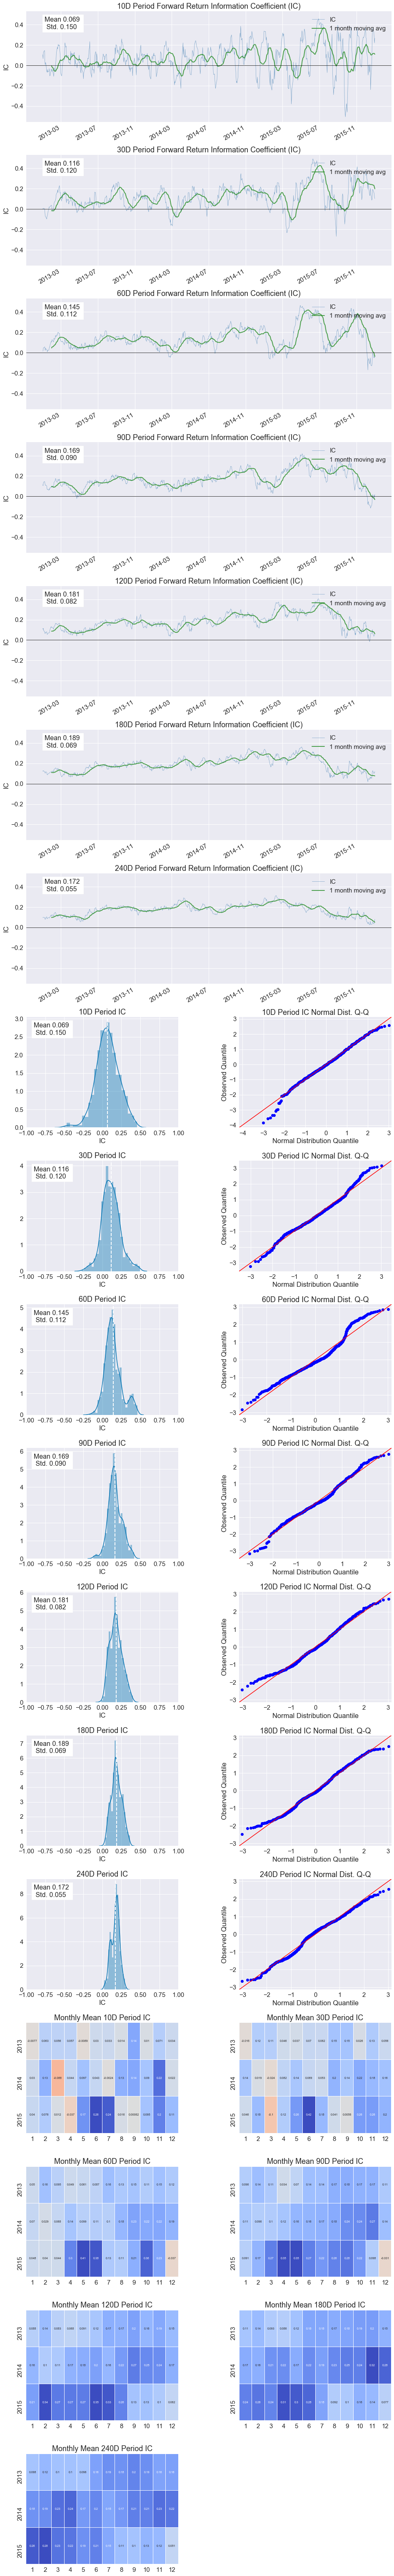

In [166]:
alphalens.tears.create_information_tear_sheet(factor_data)

# Turnover Analysis

Turnover Analysis gives us an idea about the nature of a factor's makeup and how it changes.

In [167]:
quantile_factor = factor_data['factor_quantile']
turnover_period = '1D'

In [168]:
quantile_turnover = pd.concat([quantile_turnover(quantile_factor, q, turnover_period)
                               for q in quantile_factor.unique()], axis=1)

In [169]:
quantile_turnover.head()

2         3         5         4         1
date                                                        
2013-01-01       NaN       NaN       NaN       NaN       NaN
2013-01-02  0.130000  0.166667  0.080925  0.122137  0.048544
2013-01-03  0.114583  0.194175  0.058140  0.180451  0.066667
2013-01-04  0.161616  0.155340  0.035503  0.112782  0.057143
2013-01-07  0.153061  0.183486  0.035294  0.100000  0.049020

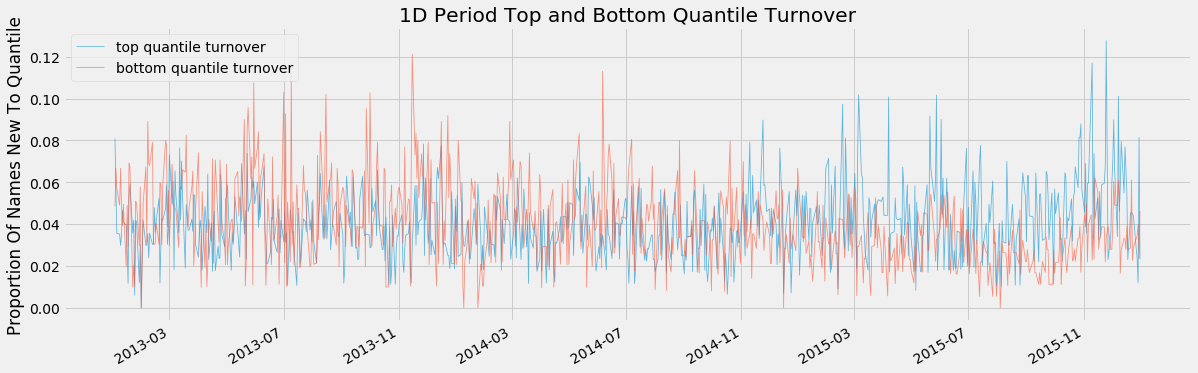

In [170]:
plot_top_bottom_quantile_turnover(quantile_turnover, turnover_period);

Factor turnover is important as it indicates the incorporation of new information and the make up of the extremes of a signal. By looking at the new additions to the sets of top and bottom quantiles we can see how much of this factor is getting remade everyday.

In [171]:
factor_autocorrelation = factor_rank_autocorrelation(factor_data, turnover_period)

In [172]:
factor_autocorrelation.head()

date
2013-01-01         NaN
2013-01-02    0.992898
2013-01-03    0.993075
2013-01-04    0.991862
2013-01-07    0.992325
Name: 1D, dtype: float64

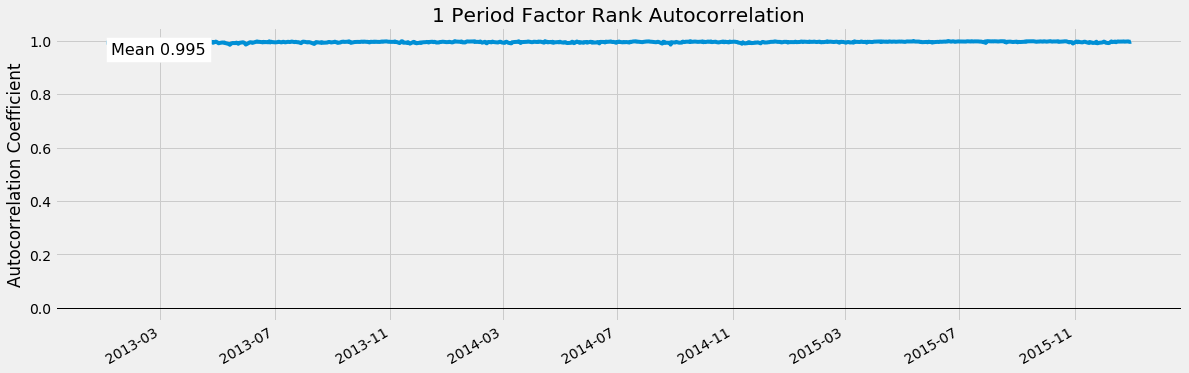

In [173]:
alphalens.plotting.plot_factor_rank_auto_correlation(factor_autocorrelation);

The autocorrelation of the factor indicates to us the persistence of the signal itself.

## Turnover Tear Sheet

We can view all turnover calculations together.

Turnover Analysis


10D   120D   180D   240D    30D    60D    90D
Quantile 1 Mean Turnover   0.132  0.464  0.574  0.678  0.232  0.326  0.401
Quantile 2 Mean Turnover   0.338  0.711  0.752  0.794  0.514  0.620  0.677
Quantile 3 Mean Turnover   0.396  0.733  0.762  0.793  0.567  0.655  0.697
Quantile 4 Mean Turnover   0.343  0.678  0.709  0.741  0.518  0.610  0.647
Quantile 5 Mean Turnover   0.130  0.419  0.498  0.584  0.224  0.311  0.371

10D    30D    60D    90D   120D   180D  \
Mean Factor Rank Autocorrelation  0.957  0.881  0.779  0.683  0.593  0.417   

                                   240D  
Mean Factor Rank Autocorrelation  0.226

<Figure size 432x288 with 0 Axes>

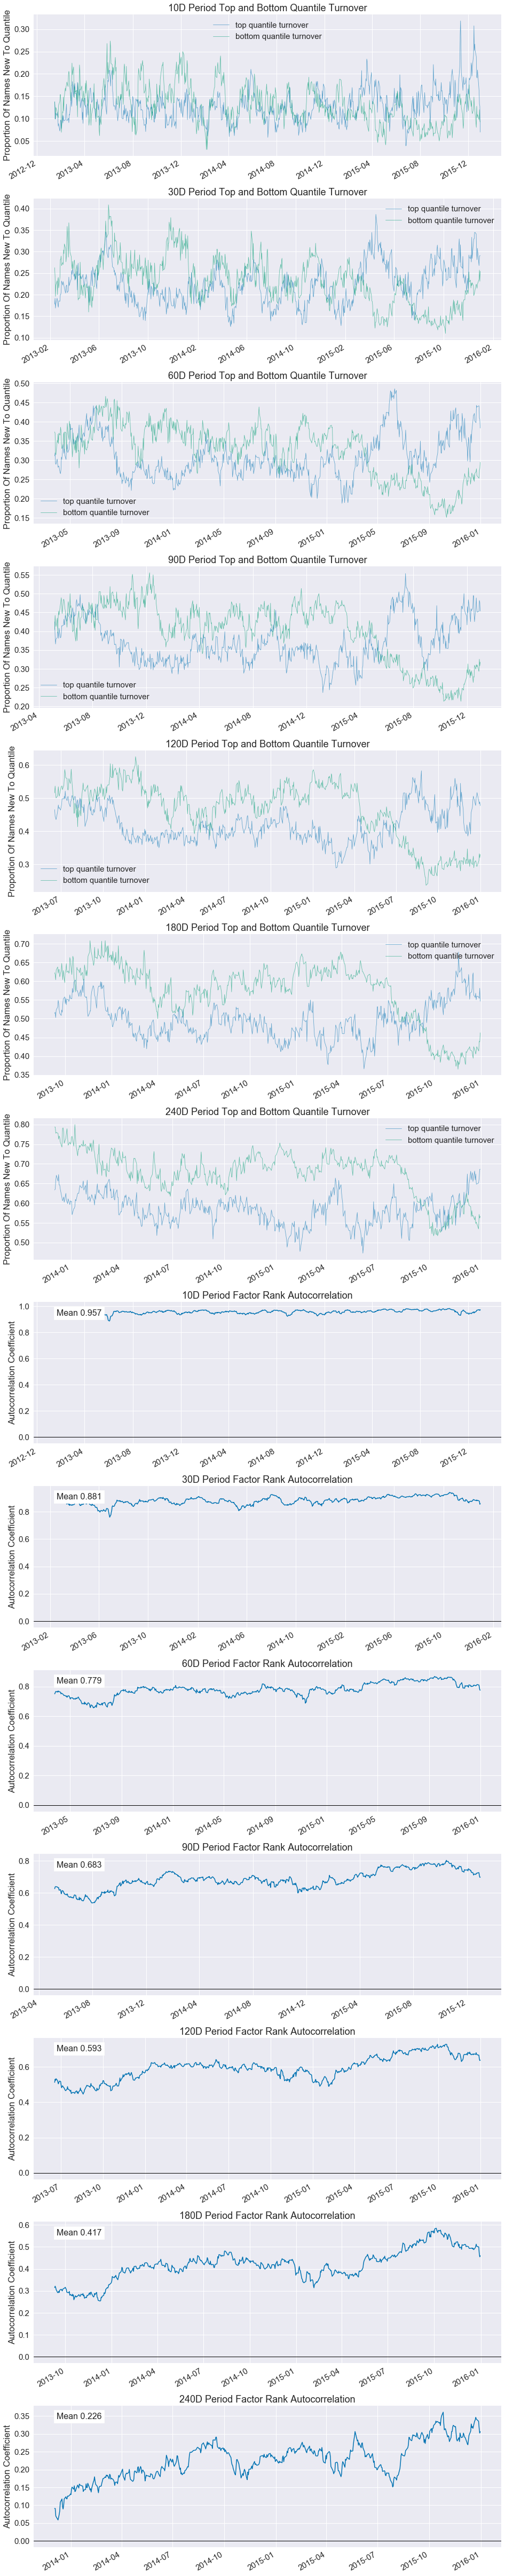

In [174]:
alphalens.tears.create_turnover_tear_sheet(factor_data)

# Event Style Returns Analysis

Looking at the average cumulative return in a window before and after a factor can indicate to us how long the predicative power of a factor lasts. This tear sheet takes a while to run.

**NOTE:** This tear sheet takes in an extra argument `pricing`.

In [ ]:
# alphalens.tears.create_event_returns_tear_sheet(factor_data, pricing, by_group=True)

# Groupwise

Many of the plots in Alphalens can be viewed on their own by grouping if grouping information is provided. The returns and information tear sheets can be viewed groupwise by passing in the `by_group=True` argument.

In [177]:
ic_by_sector = mean_information_coefficient(factor_data, by_group=True)

In [178]:
ic_by_sector.head()

10D       30D       60D       90D      120D  \
group                                                                     
Basic Industries       0.078040  0.129962  0.178217  0.215655  0.220655   
Capital Goods          0.052611  0.101041  0.138883  0.161396  0.166015   
Consumer Durables      0.045731  0.080794  0.102961  0.128070  0.152794   
Consumer Non-Durables  0.055513  0.083468  0.096936  0.111627  0.128493   
Consumer Services      0.064862  0.098047  0.099969  0.122603  0.135219   

                           180D      240D  
group                                      
Basic Industries       0.237469  0.214028  
Capital Goods          0.167870  0.118744  
Consumer Durables      0.168106  0.169399  
Consumer Non-Durables  0.170496  0.187724  
Consumer Services      0.129678  0.119758

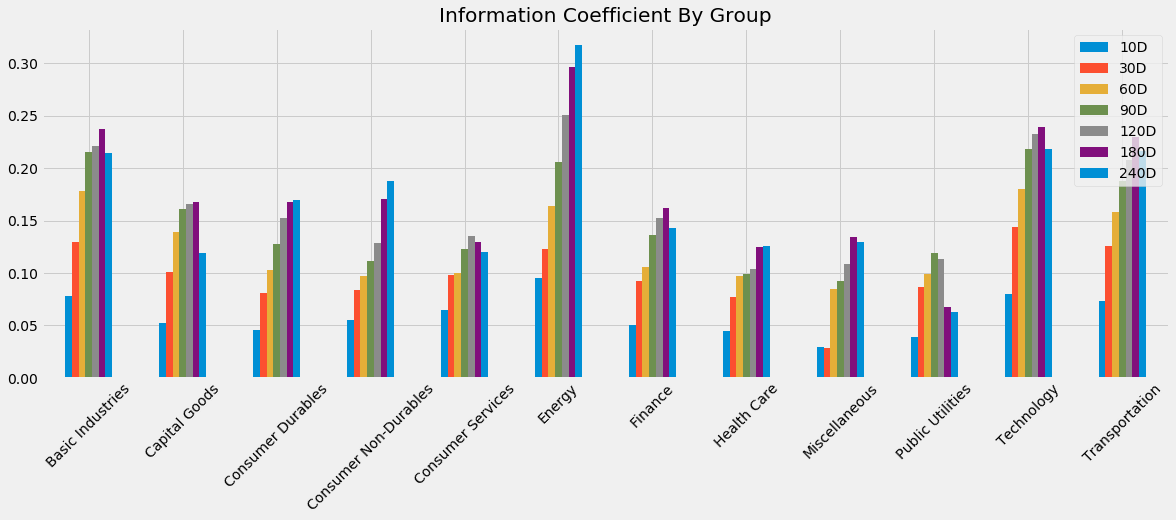

In [179]:
plot_ic_by_group(ic_by_sector);

In [180]:
mean_return_quantile_sector, mean_return_quantile_sector_err = mean_return_by_quantile(factor_data, by_group=True)

In [181]:
mean_return_quantile_sector.head()

10D       30D       60D       90D  \
factor_quantile group                                                           
1               Basic Industries      -0.009281 -0.028618 -0.053578 -0.068227   
                Capital Goods         -0.004385 -0.012457 -0.019588 -0.023414   
                Consumer Durables     -0.003700 -0.012022 -0.011307 -0.011285   
                Consumer Non-Durables -0.003004 -0.008209 -0.008159 -0.015395   
                Consumer Services     -0.004703 -0.014276 -0.021885 -0.032222   

                                           120D      180D      240D  
factor_quantile group                                                
1               Basic Industries      -0.074525 -0.075743 -0.053606  
                Capital Goods         -0.016732  0.008347  0.059627  
                Consumer Durables     -0.015578 -0.045697 -0.057383  
                Consumer Non-Durables -0.023669 -0.049114 -0.074291  
                Consumer Services     -0.043190 -0.071973 -0.091353

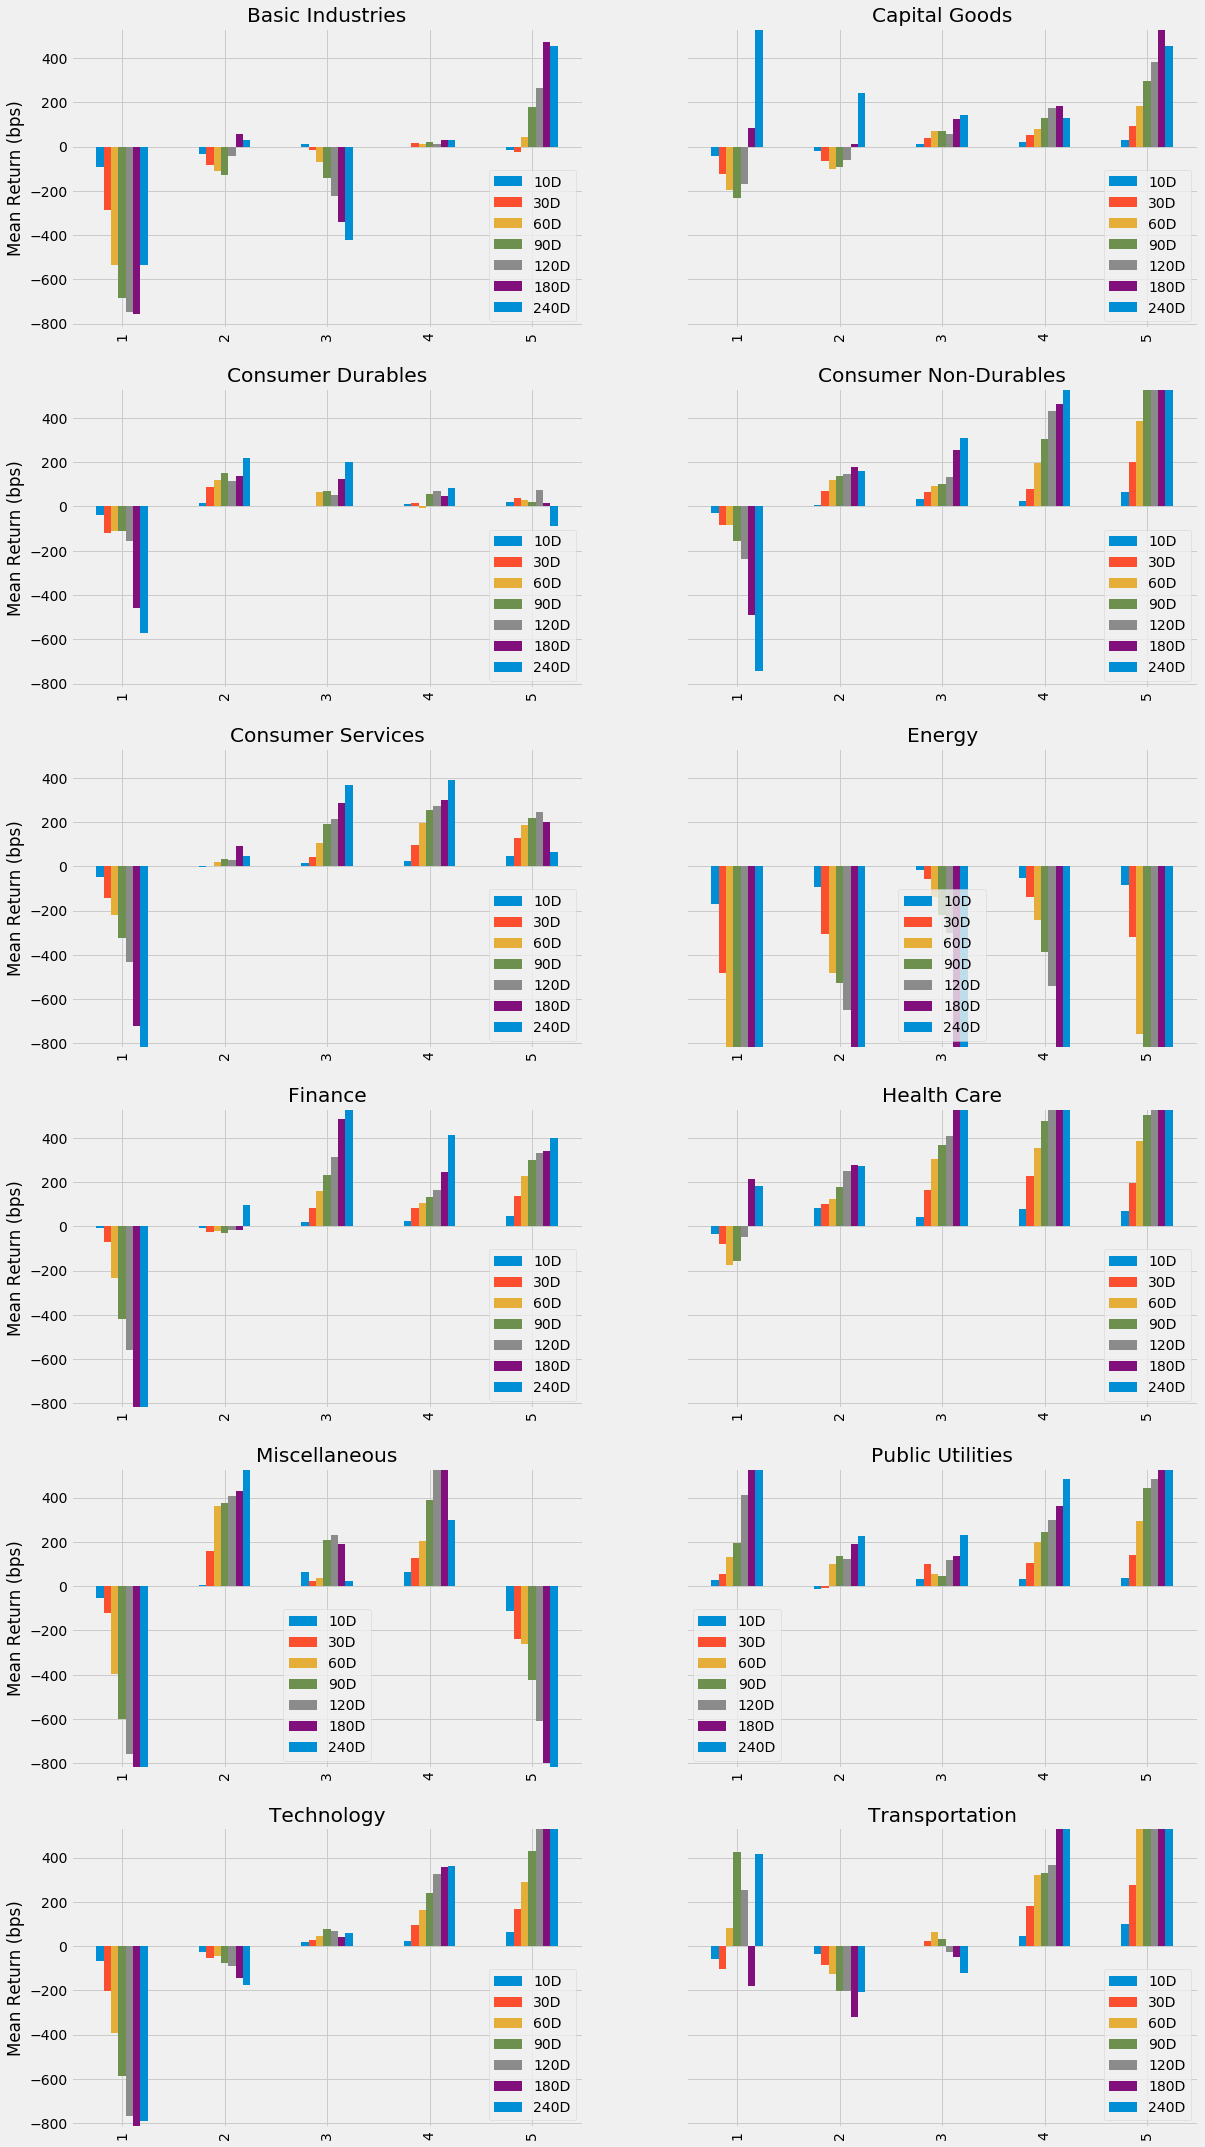

In [182]:
plot_quantile_returns_bar(mean_return_quantile_sector, by_group=True);

# The Whole Thing

If you want to see all of the results create a full tear sheet. By passing in the factor data you can analyze all of the above statistics and plots at once.

In [ ]:
alphalens.tears.create_full_tear_sheet(factor_data)

In [ ]:
factor_quantiles = factor.apply(pd.qcut, q=20, labels=False, axis=1)

In [ ]:
data = pd.concat([factor.stack().to_frame('factor'), 
                  factor_quantiles.stack().to_frame('quant')], axis=1)
data.head()

In [ ]:
res = {}
for col in corrs.columns:
    res[col] = corrs[col].abs().nlargest(50).mean()
pd.Series(res).nlargest(5)

In [ ]:
stock_returns = stock_prices.pct_change()

In [ ]:
periods = [1, 3, 5, 10, 30]
forward_returns = pd.DataFrame()
for period in periods:
    p = f'{period}D'
    forward_returns[p] = stock_returns.shift(-period).stack()
forward_returns.head()

### Returns by Quantile

In [ ]:
returns_by_quantile = pd.concat([data, forward_returns], axis=1).dropna(subset=['factor', 'quant'])
returns_by_quantile.quant = returns_by_quantile.quant.astype(int)
returns_by_quantile.info()

In [ ]:
returns_by_quantile.drop('factor', axis=1).groupby('quant').mean().plot.bar(figsize=(15,9));

### Information Coefficient

In [ ]:
ic = pd.DataFrame()
for period in periods:
    p = f'{period}D'
    correlation = returns_by_quantile.groupby('quant')['factor', p].apply(lambda x: x.factor.corr(x[p]))
    ic = pd.concat([ic, correlation.to_frame(p)], axis=1)
ic.index = ic.index.astype(int)

In [ ]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(ic.sort_index(ascending=False), annot=True, fmt='.2%', cmap=cmap, center=0, cbar=False)
plt.gcf().set_size_inches(10, 8)
plt.tight_layout();